In [1]:
import psycopg2
import config as creds
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
from numpy.random import randn
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import time

In [2]:
user=creds.PGUSER
password=creds.PGPASSWORD
host=creds.PGHOST
port=5432
database=creds.PGDATABASE

engine_str=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(engine_str)
conn = engine.raw_connection()
print('Connected')
cur = conn.cursor()
print('Cursor created')

Connected
Cursor created


In [3]:
query='''
SELECT b.kbtu
      ,b.REPORTEDBUILDINGGROSSFLOORAREA
      ,b.ward
      ,b.yearbuilt
      ,b.primarypropertytype_selfselect
      ,b.elegas
      ,n.awnd
      ,n.cldd
      ,n.htdd
      ,n.tavg
      ,n.snow
      ,n.date 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH
AND b.ELEGAS = 'E'
--AND b.PRIMARYPROPERTYTYPE_SELFSELECT = '14'
AND b.REPORTINGYEAR BETWEEN 2018 AND 2019
AND b.YEARBUILT > 0
AND b.REPORTEDBUILDINGGROSSFLOORAREA > 50000
--AND b.DCREALPROPERTYID = '0453_5030'
AND b.WARD>0;
'''

In [4]:
data=pd.read_sql(query,conn)
data['datetime']=pd.to_datetime(data['date'])
data.head()

,kbtu,reportedbuildinggrossfloorarea,ward,yearbuilt,primarypropertytype_selfselect,elegas,awnd,cldd,htdd,tavg,snow,date,datetime
0,537229.7,110784.0,2,1963,10,E,9.8,0.0,906.0,35.8,1.2,2018-01,2018-01-01
1,309401.8,115470.0,2,1959,10,E,9.8,0.0,906.0,35.8,1.2,2018-01,2018-01-01
2,468409.7,51153.0,2,1985,10,E,9.8,0.0,906.0,35.8,1.2,2018-01,2018-01-01
3,1484793.4,154807.0,2,1981,10,E,9.8,0.0,906.0,35.8,1.2,2018-01,2018-01-01
4,1294147.7,210807.0,3,1971,7,E,9.8,0.0,906.0,35.8,1.2,2018-01,2018-01-01


In [5]:
conn.close()
print('Closed')

Closed


In [6]:
TARGET = "kbtu"
COLS = ['ward', 'yearbuilt', 'primarypropertytype_selfselect', 'awnd', 'cldd', 'htdd', 'tavg', 'snow', 'datetime', 'reportedbuildinggrossfloorarea'] 
       

def make_sklearn_data(df=data, target=TARGET, cols=COLS):
    df = df.reset_index()
    X, y = df[cols], df[target]
    return X, y

<AxesSubplot:xlabel='datetime_cos', ylabel='datetime_sin'>

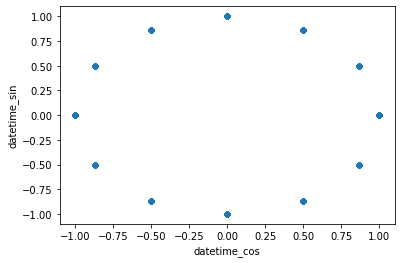

In [7]:
#CYCLIC ENCODER:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="month"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "month":
            return x.dt.month
        elif self.date_extract == "year":
            return x.dt.year
        else:
            raise NotImplementedError(f"{self.date_extract} date component not implemented yet")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(data.reset_index()["datetime"])
ce.plot(x="datetime_cos", y="datetime_sin", kind="scatter")

In [8]:
#FEATURE EXTRACTION
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

extraction = Pipeline([
    ('column_selection', ColumnTransformer([
        ('time_components', FeatureUnion([
            ('month', CyclicEncoder(date_extract='month')), 
            ('year', CyclicEncoder(date_extract='year')), 
        ]), 'datetime'),
        ('ward_one_hot', OneHotEncoder(handle_unknown='ignore'), ['ward']),
        ('yearbuilt_one_hot', OneHotEncoder(handle_unknown='ignore'), ['yearbuilt']),
        ('type_one_hot', OneHotEncoder(handle_unknown='ignore'), ['primarypropertytype_selfselect']),
    ], remainder="passthrough")),
])

extraction2 = Pipeline([
    ('column_selection', ColumnTransformer([
        ('time_components', FeatureUnion([
            ('month', CyclicEncoder(date_extract='month')), 
            ('year', CyclicEncoder(date_extract='year')), 
        ]), 'datetime'),
        ('scalar', MinMaxScaler(), ['reportedbuildinggrossfloorarea','awnd', 'cldd', 'htdd', 'tavg', 'snow']),
        ('ward_one_hot', OneHotEncoder(handle_unknown='ignore'), ['ward']),
        ('yearbuilt_one_hot', OneHotEncoder(handle_unknown='ignore'), ['yearbuilt']),
        ('type_one_hot', OneHotEncoder(handle_unknown='ignore'), ['primarypropertytype_selfselect']),
    ], remainder="passthrough")),
])

extraction3 = Pipeline([
    ('column_selection', ColumnTransformer([
        ('time_components', FeatureUnion([
            ('month', CyclicEncoder(date_extract='month')), 
            ('year', CyclicEncoder(date_extract='year')), 
        ]), 'datetime'),
        ('scalar', StandardScaler(), ['reportedbuildinggrossfloorarea','awnd', 'cldd', 'htdd', 'tavg', 'snow']),
        ('ward_one_hot', OneHotEncoder(handle_unknown='ignore'), ['ward']),
        ('yearbuilt_one_hot', OneHotEncoder(handle_unknown='ignore'), ['yearbuilt']),
        ('type_one_hot', OneHotEncoder(handle_unknown='ignore'), ['primarypropertytype_selfselect']),
    ], remainder="passthrough")),
])


In [9]:
def make_energy_pipeline(model, append_transformers=None, fe=extraction):
    pipe = clone(fe)
    
    if append_transformers:
        for step in append_transformers:
            pipe.steps.append(step)
    
    pipe.steps.append(["model", clone(model)])
    return pipe

In [10]:
#TIME SERIES CROSS VALIDATION
from functools import partial
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#rmse = partial(mean_squared_error, squared=False)


def time_series_evaluate(model, X, y):
    """
    Performs time series cross validation on the model, returning the
    cross validated r2, mse, and mae of the regressor, along with the 
    final fitted model, fitted on all of the data.
    """
    cv = TimeSeriesSplit(12)
    scores = {}
    
    scores["r2"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(r2_score))
    scores["mse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_squared_error))
   # scores["rmse"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(rmse))
    scores["mae"] = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
    
    model.fit(X, y)
    return model, scores

In [11]:
# LINEAR MODEL
from sklearn.linear_model import LinearRegression
X, y = make_sklearn_data()
lm = make_energy_pipeline(LinearRegression(),fe=extraction)
time_series_evaluate(lm, X, y)

(Pipeline(steps=[('column_selection',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('time_components',
                                                   FeatureUnion(transformer_list=[('month',
                                                                                   CyclicEncoder()),
                                                                                  ('year',
                                                                                   CyclicEncoder(date_extract='year'))]),
                                                   'datetime'),
                                                  ('ward_one_hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ward']),
                                                  ('yearbuilt_one_hot',
                                                   OneHotEncoder(hand

In [12]:
from sklearn.linear_model import LinearRegression
X, y = make_sklearn_data()
lm = make_energy_pipeline(LinearRegression(), fe=extraction2)
time_series_evaluate(lm, X, y)

KeyboardInterrupt: 

In [ ]:
# X, y = make_sklearn_data()
# lm = make_energy_pipeline(LinearRegression(), fe=extraction3)
# time_series_evaluate(lm, X, y)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# start  = time.time()
# X, y = make_sklearn_data()
# lm = make_energy_pipeline(RandomForestRegressor())
# print(time_series_evaluate(lm, X, y))
# print("Time = {:0.3f} seconds".format(time.time()-start))

In [ ]:
# import time
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import VotingRegressor

# start  = time.time()

# r1 = LinearRegression()
# r2 = RandomForestRegressor(n_estimators=10, random_state=1)

# X, y = make_sklearn_data()
# er = make_energy_pipeline(VotingRegressor([('lr', r1), ('rf', r2)]))
# print(time_series_evaluate(er, X, y))
# print("Time = {:0.3f} seconds".format(time.time()-start))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
X,y = make_sklearn_data()
criterion = ['mse','mae']
n_jobs = [1,-1]
random_state=[1,2,4,6,8]
verbose = [1,2,3,4]
n_estimators=[10,100,1000]
param_grid = dict(criterion=criterion,
                   n_jobs=n_jobs,
                   random_state=random_state,
                   verbose=verbose,
                n_estimators=n_estimators
                     )
grid= GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=param_grid,
                  scoring=['r2','neg_mean_squared_error', 'neg_mean_absolute_error'],
                  cv=TimeSeriesSplit(12),
                  refit=False)
                  
lm = make_energy_pipeline(grid)
grid_result = lm.fit(X,y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
X,y = make_sklearn_data()
criterion = ['mse','mae']
n_jobs = [1,-1]
random_state=[1,2,4,6,8]
verbose = [1,2,3,4]
n_estimators=[10,100,1000]
param_distributions = dict(criterion=criterion,
                   n_jobs=n_jobs,
                   random_state=random_state,
                   verbose=verbose,
                n_estimators=n_estimators)
random = RandomizedSearchCV(estimator=RandomForestRegressor(),
                           param_distributions=param_distributions,
                           scoring=['r2','neg_mean_squared_error', 'neg_mean_absolute_error'],
                           cv=TimeSeriesSplit(12),
                           refit=True)
rm = make_energy_pipeline(random)
random_result = random.fit(X,y)
print('Best Score: ', random_result.best_score_)
print('Best Params: ', random_result.best_params_)

ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.